In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as graph
import seaborn as sns

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from grem import GeneralRandomEffectsModel


graph.style.use('fivethirtyeight')

## Replicating the Random Effects Model

In [2]:
df = pd.read_csv('data/sleepstudy.csv', index_col=0)
x, z, group, y = df[['Days']], np.ones((len(df), 1)), df['Subject'], df['Reaction']

display(df.head())
print(df.shape)

x_train, x_test, z_train, z_test, group_train, group_test, y_train, y_test = train_test_split(x, z, group, y, test_size=0.3)
print(x_train.shape, z_train.shape, group_train.shape, y_train.shape)

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


(180, 3)
(126, 1) (126, 1) (126,) (126,)


In [3]:
%%time
# Baseline
lm = LinearRegression().fit(df[['Days', 'Subject']], df['Reaction'])
print(lm.score(df[['Days', 'Subject']], df['Reaction']))

0.31992185921289307
Wall time: 14.9 ms


In [4]:
%%timeit
lm.predict(df[['Days', 'Subject']])

489 µs ± 71.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
%%time
# Real LMM
lmm = smf.mixedlm('Reaction ~ Days', df, groups='Subject').fit()
display(lmm.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:             MixedLM Dependent Variable: Reaction 
No. Observations:  180     Method:             REML     
No. Groups:        18      Scale:              960.4568 
Min. group size:   10      Likelihood:         -893.2325
Max. group size:   10      Converged:          Yes      
Mean group size:   10.0                                 
--------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  251.405    9.747 25.794 0.000 232.302 270.508
Days        10.467    0.804 13.015 0.000   8.891  12.044
groups RE 1378.176   17.156                             
========================================================

"""

Wall time: 124 ms


In [6]:
%%time
# Fancy Model
relm = GeneralRandomEffectsModel(estimator=LinearRegression(), cv=5, verbose=True)
relm.fit(x_train, z_train, group_train, y_train)

R^2: 0.202 GLL: 1117.107 at iteration 1
R^2: 0.512 GLL: 1111.786 at iteration 2
R^2: 0.515 GLL: 1111.918 at iteration 3
R^2: 0.516 GLL: 1111.916 at iteration 4
R^2: 0.516 GLL: 1111.916 at iteration 5
Early Termination
Wall time: 332 ms


In [7]:
%%timeit
# Estimate inference runtime
relm.predict(x_train, z_train, group_train)

5.88 ms ± 774 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print(relm.score(x_train, z_train, group_train, y_train))
print(relm.score(x_test, z_test, group_test, y_test))

0.7629930741909331
0.5727340690082207


[9.85851279] 253.89164058536434


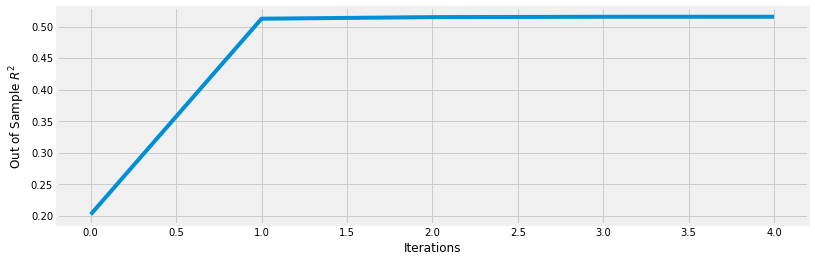

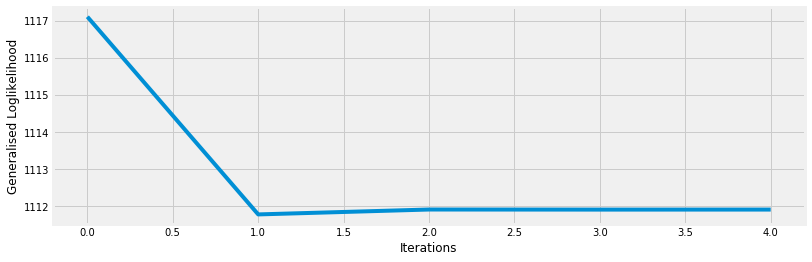

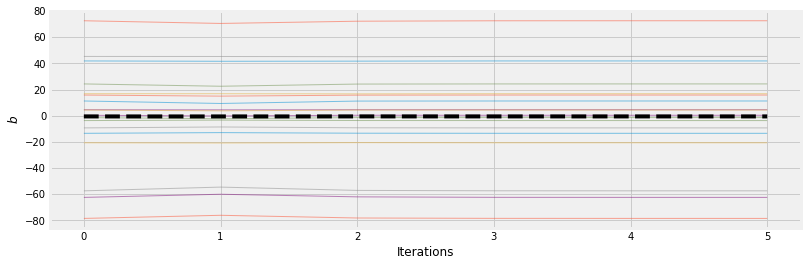

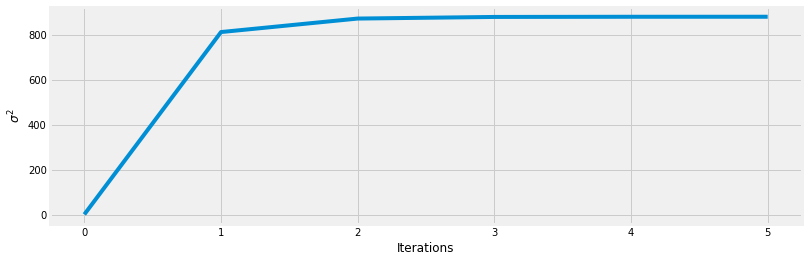

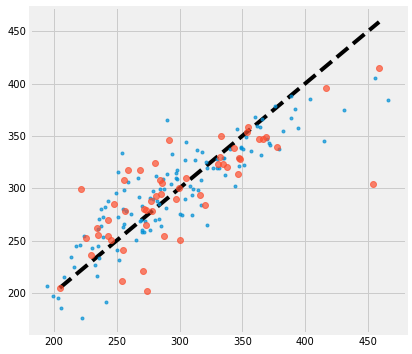

In [9]:
print(relm.estimator_.coef_, relm.estimator_.intercept_)

relm.plot_history()

graph.figure(figsize=(6, 6))
graph.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='black')
graph.plot(y_train, relm.predict(x_train, z_train, group_train), '.', label='Train', alpha=0.7)
graph.plot(y_test, relm.predict(x_test, z_test, group_test), 'o', label='Test', alpha=0.7)
graph.show()

## Arbitrary Random Effects Model 

In [10]:
radon = pd.read_csv('data/radon.csv', index_col=0)[['floor', 'Uppm', 'county', 'log_radon']]
radon = radon.rename(columns={'Uppm': 'uppm'})

county_encoder = LabelEncoder()
county_encoder.fit(radon['county'])
radon['county'] = county_encoder.transform(radon['county'])

display(radon.head())
print(radon.shape)

radon_train, radon_test = train_test_split(radon, test_size=0.2)
print(radon_train.shape, radon_test.shape)

def create_rfx_data(d):
    x = d[['floor', 'uppm']]
    y = d['log_radon']
    g = d['county']
    z = np.ones((len(x), 1))
    return x, z, g, y

x_train, z_train, g_train, y_train = create_rfx_data(radon_train)
x_test, z_test, g_test, y_test = create_rfx_data(radon_test)
print(x_train.shape, z_train.shape, g_train.shape, y_train.shape)

,floor,uppm,county,log_radon
0,1.0,0.502054,0,0.832909
1,0.0,0.502054,0,0.832909
2,0.0,0.502054,0,1.098612
3,0.0,0.502054,0,0.095310
4,0.0,0.428565,1,1.163151


(919, 4)
(735, 4) (184, 4)
(735, 2) (735, 1) (735,) (735,)


In [11]:
%%time
grid_model = GridSearchCV(
    RandomForestRegressor(n_jobs=-1), 
    {'n_estimators': [50, 100, 300], 'max_depth': [4, 8, 15], 'min_samples_leaf': [3, 5, 10]},
    cv=5
)
grid_model.fit(radon_train.drop(columns='log_radon'), radon_train['log_radon'])

print(grid_model.best_params_)

{'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 50}
Wall time: 58.6 s


In [12]:
%%time
# Baseline
rf = grid_model.best_estimator_
rf.fit(radon_train.drop(columns='log_radon'), radon_train['log_radon'])

Wall time: 162 ms


In [13]:
print(rf.score(radon_train.drop(columns='log_radon'), radon_train['log_radon']))
print(rf.score(radon_test.drop(columns='log_radon'), radon_test['log_radon']))

0.24052142982277425
0.15833834454207263


In [14]:
%%time
# Fancy Model
rerf = GeneralRandomEffectsModel(grid_model.best_estimator_, max_iterations=20, cv=5, verbose=True)
rerf.fit(x_train, z_train, g_train, y_train)

R^2: 0.143 GLL: 158.972 at iteration 1
R^2: 0.192 GLL: 98.527 at iteration 2
R^2: 0.186 GLL: 82.401 at iteration 3
R^2: 0.189 GLL: 63.092 at iteration 4
R^2: 0.185 GLL: 53.969 at iteration 5
R^2: 0.183 GLL: 44.392 at iteration 6
R^2: 0.184 GLL: 36.679 at iteration 7
R^2: 0.178 GLL: 33.445 at iteration 8
R^2: 0.175 GLL: 27.444 at iteration 9
R^2: 0.173 GLL: 22.872 at iteration 10
R^2: 0.174 GLL: 16.654 at iteration 11
R^2: 0.169 GLL: 16.264 at iteration 12
R^2: 0.166 GLL: 11.547 at iteration 13
R^2: 0.169 GLL: 5.107 at iteration 14
R^2: 0.167 GLL: 2.860 at iteration 15
R^2: 0.168 GLL: -1.859 at iteration 16
R^2: 0.165 GLL: -3.594 at iteration 17
R^2: 0.164 GLL: -5.869 at iteration 18
R^2: 0.165 GLL: -9.724 at iteration 19
R^2: 0.165 GLL: -12.481 at iteration 20
Wall time: 30.4 s


In [15]:
%%timeit
# Estimate inference runtime
rerf.predict(x_train, z_train, g_train)

132 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


0.26263560020074306
0.14720792710670616


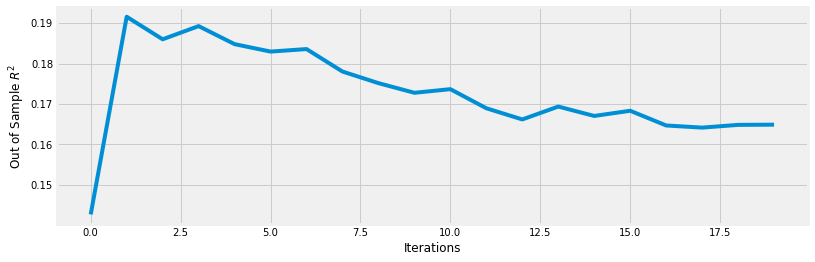

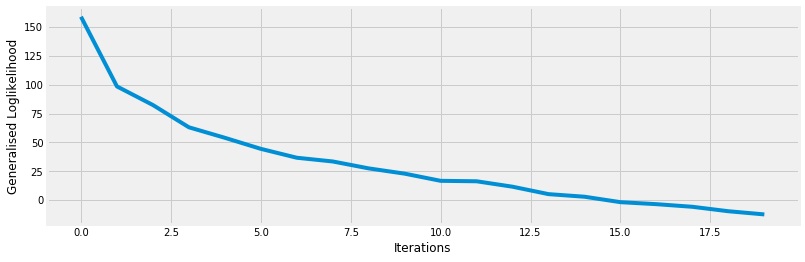

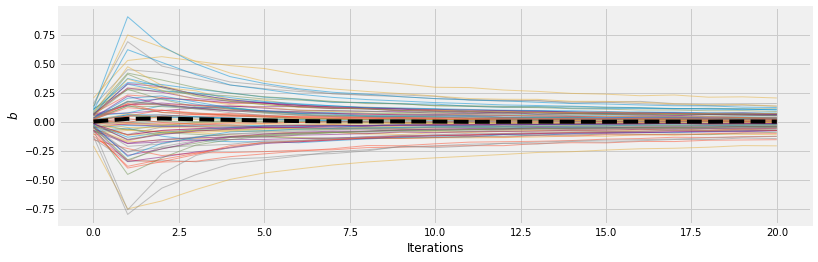

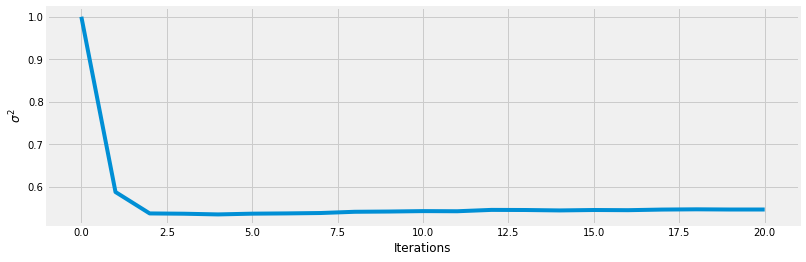

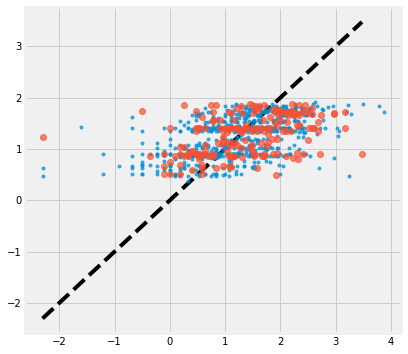

In [16]:
print(rerf.score(x_train, z_train, g_train, y_train))
print(rerf.score(x_test, z_test, g_test, y_test))

rerf.plot_history()

graph.figure(figsize=(6, 6))
graph.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='black')
graph.plot(y_train, rerf.predict(x_train, z_train, g_train), '.', label='Train', alpha=0.7)
graph.plot(y_test, rerf.predict(x_test, z_test, g_test), 'o', label='Test', alpha=0.7)
graph.show()